In [1]:
import math
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves price attribute to PT LoS table
## Needs PT LoS table and links

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
los = stepmodel.read_json(model_path + 'de_pt_los')

In [4]:
sm.pt_los = los.pt_los

In [5]:
# Cost function
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [6]:
# Load list of distance-related cost
c = pd.read_csv(input_path + 'level_of_service_DB_2020_preisliste_fahrplanjahr_2020.csv')
c.head(3)

,km,single_trip_second_class,single_trip_first_class,return_trip_second_class,return_trip_first_class
0,37.0,10.1,16.2,20.2,32.4
1,38.0,10.3,16.5,20.6,33.0
2,39.0,10.4,16.6,20.8,33.2


<AxesSubplot:xlabel='km'>

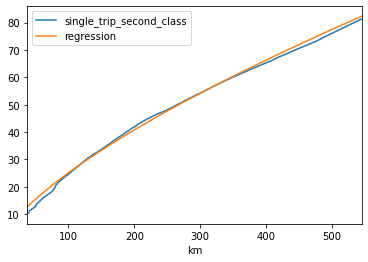

In [7]:
# Use second class single trip prices
# Choose a fit for a distance range up to 1000 km (longer trips are rare)
rf_rail = 0.7
c['regression'] = c['km'].apply(lambda km: math.pow(km, rf_rail))
c.loc[0:500, ['km', 'single_trip_second_class', 'regression']].set_index('km').plot()

In [8]:
# Bus trips are free but get a fare assigned in LOS table
sm.links['price'] = 0

In [9]:
# Generate length for PT links as the crow flies
if 'length' not in sm.links.columns:
    sm.links['length'] = sm.links['geometry'].apply(
        lambda l: geodesic(l.coords[0], l.coords[-1]).m)

In [10]:
# Long distance rail links
# Will be revised later
sm.links.loc[sm.links['route_type']=='rail_long_distance', 'price'] = \
    sm.links['length'].apply(lambda l: monetary_cost(l/1000, rf_rail, 1,
                                                     0, 0, 0, 0, 1))

In [11]:
# Short distance rail links
sm.links.loc[sm.links['route_type']=='rail_short_distance', 'price'] = \
    sm.links['length'].apply(lambda l: monetary_cost(l/1000, rf_rail, 1,
                                                     0, 0, 0, 0, 1))

In [12]:
# Coach links
# Average cost in Germany: https://de.statista.com/statistik/daten/studie/380601/umfrage/kilometerpreise-fernbuslinien-in-deutschland/
sm.links.loc[sm.links['route_type']=='coach', 'price'] = \
    sm.links['length'].apply(lambda l: monetary_cost(l/1000, 1, 0.107,
                                                     0, 0, 0, 0, 1))

Average economy price: 94.22058823529412 EUR
Average business price: 277.8235294117647 EUR


<AxesSubplot:xlabel='time'>

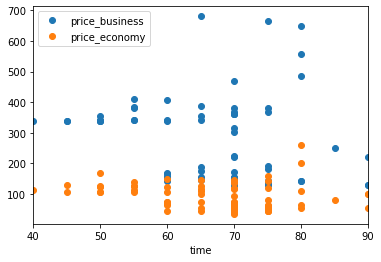

In [13]:
# Air links: Match them with prices from Sept. 2020
# Load connection list
air = pd.read_excel(input_path + 'public_transport_air_connections_germany.xlsx', engine='xlrd')
air = air.loc[air['direct']==True]
air['a'] = air['origin'].str[:3]
air['b'] = air['destination'].str[:3]
print('Average economy price: {} EUR'.format(air['price_economy'].mean()))
print('Average business price: {} EUR'.format(air['price_business'].mean()))
air[['price_business', 'price_economy', 'time']].set_index('time').plot(linestyle=' ', marker='o')

In [14]:
# Correct air time if neccessary
if sm.links.loc[sm.links['route_type']=='air', 'time'].mean() < 5*60:
    # Convert time to seconds
    sm.links.loc[sm.links['route_type']=='air', 'time'] = \
        sm.links.loc[sm.links['route_type']=='air', 'time'] * 60

In [15]:
# Air trips
# Take the economy price because its share is higher
# than 90% within Germany
air['trip'] = air['a'] + '-' + air['b']
price_dict = air.set_index('trip', drop=True)['price_economy'].to_dict()
sm.links.loc[sm.links['route_type']=='air', 'price'] = \
    sm.links.loc[sm.links['route_type']=='air', 'trip_id'].map(price_dict)
print(len(sm.links.loc[(sm.links['route_type']=='air') & (sm.links['price'].isna())]))
sm.links.loc[sm.links['route_type']=='air'].head(3)

0


,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway,price
index,,,,,,,,,,,
air_0,HAM,DUS,air,"LINESTRING (9.98823 53.63040, 6.76678 51.28950)",1,air_0,3600,HAM-DUS,439767,5400,65.0
air_1,HAM,CGN,air,"LINESTRING (9.98823 53.63040, 7.14274 50.86590)",1,air_1,3600,HAM-CGN,437766,5400,72.0
air_2,HAM,FRA,air,"LINESTRING (9.98823 53.63040, 8.57056 50.03333)",1,air_2,4200,HAM-FRA,425174,5400,145.0


In [16]:
# Sum up prices in LoS table based on link fares
price_dict = sm.links['price'].to_dict()
sm.pt_los['price'] = sm.pt_los['link_path'].apply(
    lambda l: sum([price_dict[link] for link in l]))

In [17]:
# Add a fare for local transport services
# Average value from ADAC: https://www.adac.de/reise-freizeit/ratgeber/tests/oepnv-preise-vergleich/
sm.pt_los.loc[sm.pt_los['route_types'].apply(
    lambda t: 'bus' in t), 'price'] = \
    sm.pt_los['price'] + 2.74

In [18]:
sm.pt_los.groupby('route_type').agg(
    {'time': 'mean', 'price': 'mean', 'length': 'mean', 'ntransfers': 'mean'})

,time,price,length,ntransfers
route_type,,,,
air,19718.000225,173.560856,731607.712713,5.660021
bus,9398.141161,2.740000,157404.292556,6.655016
coach,21902.892653,41.464336,439771.719054,4.973512
rail_long_distance,18638.897839,158.773213,559020.426410,4.606841
rail_short_distance,16400.948249,138.235003,379827.217119,4.029631
walk,159.216749,0.000000,0.000000,0.000000


In [19]:
print(sm.pt_los.columns)
print(sm.pt_los.shape)
sm.pt_los.sample(3)

Index(['origin', 'destination', 'link_path', 'ntransfers', 'access_time',
       'footpath_time', 'in_vehicle_time', 'waiting_time', 'time', 'price',
       'length', 'route_types', 'route_type'],
      dtype='object')
(1440972, 13)


,origin,destination,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,price,length,route_types,route_type
index,,,,,,,,,,,,,
703733,DEB3J,DE274,"[rail_short_42638, rail_short_83128, rail_shor...",5,1736,0,10980,3600,16316,117.680487,355959,"[rail_short_distance, rail_long_distance]",rail_long_distance
342173,DE409,DEA58,"[bus_1643099, bus_1643100, bus_1797570, bus_35...",8,1518,678,22980,5400,30576,86.465681,875124,"[bus, coach]",coach
468301,DE40F,DEF02,"[bus_638263, rail_short_42506, rail_short_4250...",6,2018,991,5520,4200,12729,59.525024,281717,"[bus, rail_short_distance]",rail_short_distance


## Save

In [20]:
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:26<00:00,  1.31it/s]


In [21]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'length', 'headway', 'price']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [22]:
sm.to_json(model_path + 'de_pt_network_agg', only_attributes=[
    'zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|██████████████████████████████████████████████████████████████████| 35/35 [00:58<00:00,  1.68s/it]


In [23]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')